In [464]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa.statespace.sarimax as smax
print('Libraries imported.')

Libraries imported.


In [73]:
# importing data
df = pd.read_csv('data.csv')
df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/2016,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/2016,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/2016,1/11/2016,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/2016,2/3/2016,2/3/2016,Toyota,Corolla,2016.0,2/3/2016
4,5,Strark,android web,Referral,1/10/2016,1/25/2016,1/26/2016,Hyundai,Sonata,2016.0,NaN


THOUGHT: Since there are a lot of missing values here, we need to check the summary of data to see the comprehensiveness of data.

In [74]:
# summary analysis
print('Summary analysis:')
print('Number of cities covered: ',len(df['city_name'].unique()))
print('Number of sign-ups: ', len(df['signup_date'].dropna()))
print('Number of background checks completed: ', len(df['bgc_date'].dropna()))
print('Number of vehicles added: ', len(df['vehicle_added_date'].dropna()))
print('Number of actual drivers: ', len(df['first_completed_date'].dropna()))

print('\nData completeness check:')
for i in range(len(list(df))):
    if(len(df.ix[:,i].unique()) == len(df.ix[:,i])):
        print('Column ',list(df)[i],' is unique.')
for i in range(len(list(df))):
    if(len(df[df.ix[:,i].isnull() == True]) > 0):
        print('Column ',list(df)[i],' blanks: ', \
              len(df[df.ix[:,i].isnull() == True]))
print('\n')
df.info()

Summary analysis:
Number of cities covered:  3
Number of sign-ups:  54681
Number of background checks completed:  32743
Number of vehicles added:  13134
Number of actual drivers:  6137

Data completeness check:
Column  id  is unique.
Column  signup_os  blanks:  6857
Column  bgc_date  blanks:  21938
Column  vehicle_added_date  blanks:  41547
Column  vehicle_make  blanks:  41458
Column  vehicle_model  blanks:  41458
Column  vehicle_year  blanks:  41458
Column  first_completed_date  blanks:  48544


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 11 columns):
id                      54681 non-null int64
city_name               54681 non-null object
signup_os               47824 non-null object
signup_channel          54681 non-null object
signup_date             54681 non-null object
bgc_date                32743 non-null object
vehicle_added_date      13134 non-null object
vehicle_make            13223 non-null object
vehicle_model         

THOUGHT: Only 11% of the total drivers which sign-up eventually end up completing the first ride. We need to perform some exploration to check if there are any patterns or anomalies.

In [75]:
# preparing data for analysis
cities = list(df["city_name"].unique())
df["city_name"] = df["city_name"].astype("category")
df["city_name"].cat.set_categories(cities, inplace=True)

df["signup_os"] = df["signup_os"].fillna('missing')
signupos = list(df["signup_os"].unique())
df["signup_os"] = df["signup_os"].astype("category")
df["signup_os"].cat.set_categories(signupos, inplace=True)

signupch = list(df["signup_channel"].unique())
df["signup_channel"] = df["signup_channel"].astype("category")
df["signup_channel"].cat.set_categories(signupch, inplace=True)

df['signup_date'] = pd.to_datetime(df['signup_date'])
df['bgc_date'] = pd.to_datetime(df['bgc_date'])
df['vehicle_added_date'] = pd.to_datetime(df['vehicle_added_date'])
df['first_completed_date'] = pd.to_datetime(df['first_completed_date'])
print('Data formatting completed.')
df.head()

Data formatting completed.


,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,NaT
1,2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,NaT
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,NaT
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016.0,2016-02-03
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016.0,NaT


THOUGHT: Assuming that the actual driver onboarding process is as follows:<br>
Sign-up -> Background check -> Vehicle Addition -> First Trip<br>
I wish to check if there is some anomaly from the above process.

In [76]:
# anomaly detection
print('Number of drivers who completed background check without sign-up date: ', \
      len(df['id'][(df['signup_date'].isnull() == True) & (df["bgc_date"].isnull() == False)]))
print('Number of drivers who completed vehicle addition without background check: ', \
      len(df['id'][(df['bgc_date'].isnull() == True) & (df["vehicle_added_date"].isnull() == False)]))
print('Number of drivers who completed vehicle addition without sign-up date: ', \
      len(df['id'][(df['signup_date'].isnull() == True) & (df["vehicle_added_date"].isnull() == False)]))
print('Number of drivers who completed first trip without vehicle addition: ', \
      len(df['id'][(df['vehicle_added_date'].isnull() == True) & (df["first_completed_date"].isnull() == False)]))
print('Number of drivers who completed first trip without background check: ', \
      len(df['id'][(df['bgc_date'].isnull() == True) & (df["first_completed_date"].isnull() == False)]))
print('Number of drivers who completed first trip without sign-up date: ', \
      len(df['id'][(df['signup_date'].isnull() == True) & (df["first_completed_date"].isnull() == False)]))

Number of drivers who completed background check without sign-up date:  0
Number of drivers who completed vehicle addition without background check:  340
Number of drivers who completed vehicle addition without sign-up date:  0
Number of drivers who completed first trip without vehicle addition:  265
Number of drivers who completed first trip without background check:  153
Number of drivers who completed first trip without sign-up date:  0


THOUGHT: I can either discard these entries or assume that the data is missing. Assuming that the process is being duly followed, the presence of subsequent onboarding dates in absence of the prior dates can only mean I have some missing data. Since the numbers are small, I ignore these for now.

In [77]:
# sign-up OS missing value analysis
print(pd.pivot_table(df,index=["city_name", "signup_channel"], columns=["signup_os"], \
                     values = ["id"], aggfunc = len, margins = True))
df.loc[df.first_completed_date.isnull() == True, 'ftc_fac'] = 0
df.loc[df.first_completed_date.isnull() == False, 'ftc_fac'] = 1
print(pd.pivot_table(df,index=["signup_os"], columns = ['ftc_fac'], values = ["id"], aggfunc = len, margins = True))

                               id                                              \
signup_os                 ios web windows android web missing     mac   other   
city_name signup_channel                                                        
Strark    Paid             3858.0  1708.0      4499.0    57.0  1311.0   974.0   
          Organic          1814.0   966.0      1529.0  1615.0   929.0   430.0   
          Referral         2733.0   690.0      2518.0  2823.0   748.0   355.0   
Wrouver   Paid              921.0   491.0       772.0    13.0   271.0   322.0   
          Organic           286.0   198.0       205.0   325.0   168.0   121.0   
          Referral          351.0   112.0       264.0    13.0    89.0    85.0   
Berton    Paid             2944.0  1410.0      2600.0    33.0  1033.0   721.0   
          Organic          1427.0   697.0      1052.0   592.0   699.0   374.0   
          Referral         2298.0   504.0      1505.0  1386.0   576.0   266.0   
All                       16

OBSERVATIONS:
1. These sign-up OS missing values seem to be occuring across cities and channels.
2. Almost 98% of sign-ups with missing OS values do not complete the first trip.

In [78]:
# BGC date missing value analysis
df.loc[df.bgc_date.isnull() == True, 'bgc_fac'] = 0
df.loc[df.bgc_date.isnull() == False, 'bgc_fac'] = 1
print(pd.pivot_table(df,index=["signup_os"], columns = ['bgc_fac'], values = ["id"], aggfunc = len, margins = True))

                  id                  
bgc_fac          0.0      1.0      All
signup_os                             
ios web       5882.0  10750.0  16632.0
windows       2369.0   4407.0   6776.0
android web   5623.0   9321.0  14944.0
missing       4865.0   1992.0   6857.0
mac           1929.0   3895.0   5824.0
other         1270.0   2378.0   3648.0
All          21938.0  32743.0  54681.0


OBSERVATION: 
1. Majority of the missing OS value also do not have BGC values.

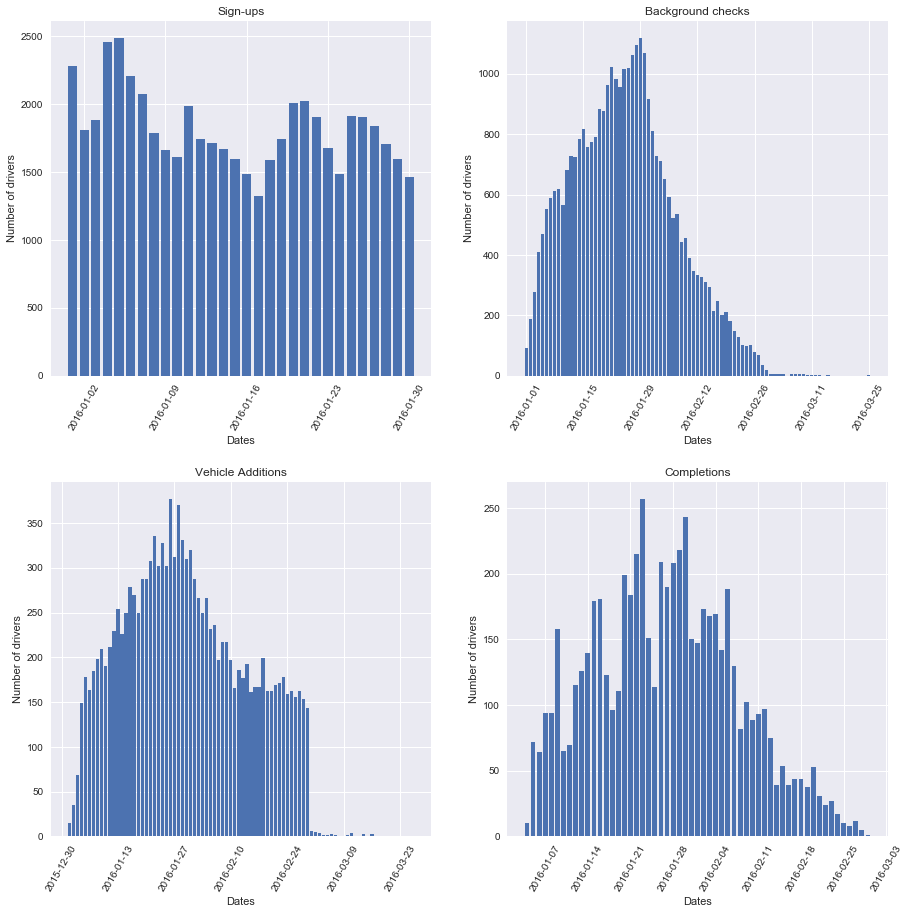

In [79]:
# trending the number of drivers
f = plt.figure()
f, axarr = plt.subplots(2, 2, figsize=(15,15))

date = list(df.groupby('signup_date').groups.keys())
su = df.groupby(['signup_date'])['id'].count()
axarr[0, 0].bar(date, su)
axarr[0, 0].set_title('Sign-ups')
axarr[0, 0].set_xlabel('Dates')
axarr[0, 0].set_ylabel('Number of drivers')

date = list(df.groupby('bgc_date').groups.keys())
bgc = df.groupby(['bgc_date'])['id'].count()
axarr[0, 1].bar(date, bgc)
axarr[0, 1].set_title('Background checks')
axarr[0, 1].set_xlabel('Dates')
axarr[0, 1].set_ylabel('Number of drivers')

date = list(df.groupby('vehicle_added_date').groups.keys())
v_add = df.groupby(['vehicle_added_date'])['id'].count()
axarr[1, 0].bar(date, v_add)
axarr[1, 0].set_title('Vehicle Additions')
axarr[1, 0].set_xlabel('Dates')
axarr[1, 0].set_ylabel('Number of drivers')

date = list(df.groupby('first_completed_date').groups.keys())
comp = df.groupby(['first_completed_date'])['id'].count()
axarr[1, 1].bar(date, comp)
axarr[1, 1].set_title('Completions')
axarr[1, 1].set_xlabel('Dates')
axarr[1, 1].set_ylabel('Number of drivers')

f.subplots_adjust(hspace = 0.3)

for i in range(2):
    for j in range(2):
        plt.setp(axarr[i, j].get_xticklabels(), rotation = 60, horizontalalignment = 'center')
plt.show()

OBSERVATIONS -
1. The sign-ups show a strong weekly dip on the weekends.
2. Most of the background checks have been completed by mid-February 2016
3. Vehicle additions almost dropped to zero in March 2016 (may indicate incomplete data or change in policy)

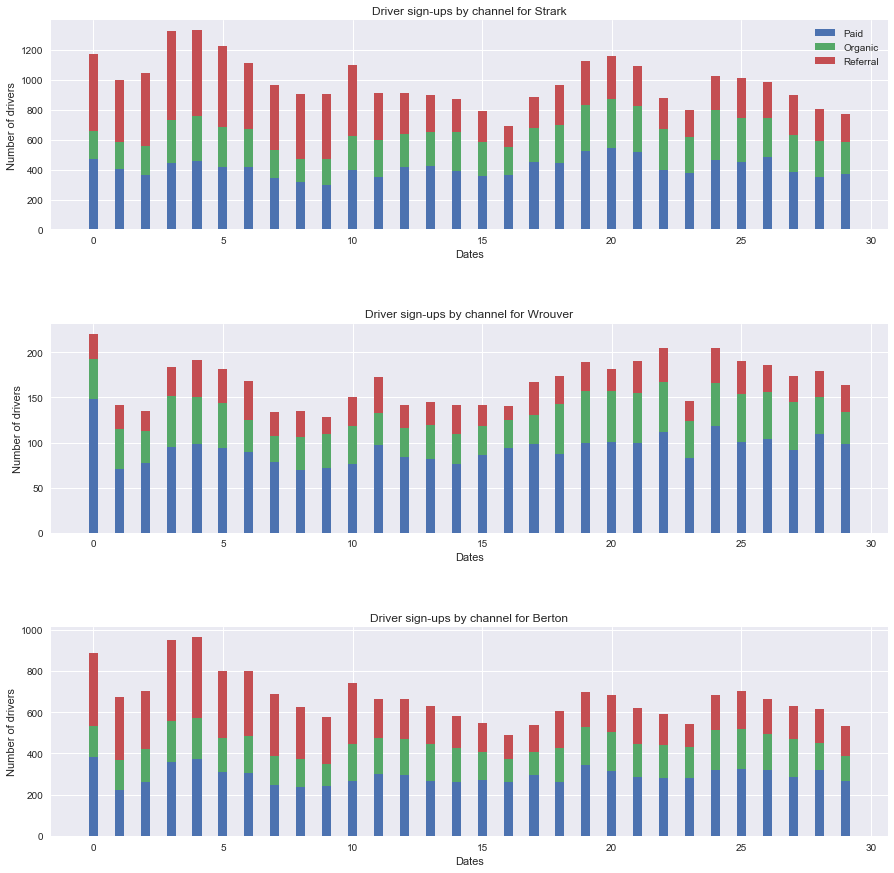

In [64]:
# checking channel-wise sign-ups across cities
table = pd.pivot_table(df,index=['city_name', "signup_channel"], columns = ['signup_date'], \
                       values = ["id"], aggfunc = len, margins = True)
mat = table.as_matrix(columns=None)
mat = np.delete(mat, 30, 1)
strark = np.zeros((3,30))
wrouver = np.zeros((3,30))
berton = np.zeros((3,30))
date = list(df.groupby('signup_date').groups.keys())
width = 0.35

for i in range(9):
    if(i < 3):
        strark[i] = mat[i]
    elif((i >= 3) and (i < 6)):
        wrouver[i - 3] = mat[i]
    elif((i >= 6) and (i < 9)):
        berton[i - 6] = mat[i]

f = plt.figure(figsize = (15,15))
ax1 = f.add_subplot(311)
p1 = plt.bar(np.arange(30), list(strark[0,]), width)
p2 = plt.bar(np.arange(30), list(strark[1,]), width, bottom = list(strark[0,]))
p3 = plt.bar(np.arange(30), list(strark[2,]), width, bottom = list(strark[0,] + strark[1,]))
ax1.set_title('Driver sign-ups by channel for Strark')
ax1.set_xlabel('Dates')
ax1.set_ylabel('Number of drivers')
ax1.legend((p1[0], p2[0], p3[0]), ('Paid', 'Organic', 'Referral'))

ax2 = f.add_subplot(312)
p4 = plt.bar(np.arange(30), list(wrouver[0,]), width)
p5 = plt.bar(np.arange(30), list(wrouver[1,]), width, bottom = list(wrouver[0,]))
p6 = plt.bar(np.arange(30), list(wrouver[2,]), width, bottom = list(wrouver[0,] + wrouver[1,]))
ax2.set_title('Driver sign-ups by channel for Wrouver')
ax2.set_xlabel('Dates')
ax2.set_ylabel('Number of drivers')

ax3 = f.add_subplot(313)
p7 = plt.bar(np.arange(30), list(berton[0,]), width)
p8 = plt.bar(np.arange(30), list(berton[1,]), width, bottom = list(berton[0,]))
p9 = plt.bar(np.arange(30), list(berton[2,]), width, bottom = list(berton[0,] + berton[1,]))
ax3.set_title('Driver sign-ups by channel for Berton')
ax3.set_xlabel('Dates')
ax3.set_ylabel('Number of drivers')


f.subplots_adjust(hspace = 0.45)
plt.show()

OBSERVATION: 
1. On 4th and 5th of January 2016, there is an increase in Referral channel sign-ups in Strark and Berton. This may be due to a marketing campaign. 
2. Apart from some expected deviations (like spike in driver sign-up on New Year's Day and the weekly trend mentioned before), the constribution of every channel is roughly constant.



On the basis of the given data, the baseline model would predict that no driver would complete the first trip.<br>
The accuracy of this can be calculated as:<br>
Accuracy = (54681 - 6137)/54681 = 88.78%

A simple SVM model with factors derived from 'city_name', 'signup_os', 'signup_channel' , 'bgc_date' and 'vehicle_added_date' was found to beat the baseline model in accuracy, but we can't use all these factors because of two reasons:
1. Many of these factors are unknown to us at the time of sign-up.
2. Many of these factors have null values for more than half the data, which makes them useless by themselves.

Also, considering the class imbalance in the dataset and the objective of finding the drivers who will perform the first trip, I believe we should focus our attention on the TPR or the Sensitivity.<br>
In the above naive model, TPR = 0.

Assuming that we only have visibility of the date, OS, channel and city at the time of sign-up, we will try to predict if the driver will complete the background check on the basis of these. This automatically discards 'vehicle_make', 'vehicle_model' and 'vehicle_year' as we apparently do not have that information at the time of sign-up.

We will convert 'city_name', 'signup_os' and 'signup_channel' to factors before running models to imply there is no order or "distance" between discrete categories of each of these columns.

In [122]:
# creating feature table for classification
feat_table = df.copy() 
feat_table['dayofweek'] = feat_table['signup_date'].dt.dayofweek
dayofweek = list(feat_table["dayofweek"].unique())
feat_table["dayofweek"] = feat_table["dayofweek"].astype("category")
feat_table["dayofweek"].cat.set_categories(dayofweek, inplace=True)

binary_encoded = pd.get_dummies(df.city_name)
city_name_fac = binary_encoded.columns
df[city_name_fac] = binary_encoded

binary_encoded = pd.get_dummies(df.signup_os)
signup_os_fac = binary_encoded.columns
df[signup_os_fac] = binary_encoded

binary_encoded = pd.get_dummies(df.signup_channel)
signup_channel_fac = binary_encoded.columns
df[signup_channel_fac] = binary_encoded

df.loc[df.bgc_date.isnull() == True, 'bgc_fac'] = 0
df.loc[df.bgc_date.isnull() == False, 'bgc_fac'] = 1

feat_table = feat_table.drop(['id', 'city_name', 'signup_channel', 'signup_os', 'signup_date', \
                              'bgc_date', 'vehicle_make', 'vehicle_model', 'vehicle_year', 'vehicle_added_date', \
                              'first_completed_date', 'ftc_fac'], axis = 1)
feat_table.head()

,bgc_fac,Strark,Wrouver,Berton,ios web,windows,android web,missing,mac,other,Paid,Organic,Referral,dayofweek
0,0.0,1,0,0,1,0,0,0,0,0,1,0,0,5
1,0.0,1,0,0,0,1,0,0,0,0,1,0,0,3
2,1.0,0,1,0,0,1,0,0,0,0,0,1,0,0
3,1.0,0,0,1,0,0,1,0,0,0,0,0,1,4
4,1.0,1,0,0,0,0,1,0,0,0,0,0,1,6


For interpretability, I will use logistic regression.

In [123]:
# Logistic Regression to predict bgc_fac
from sklearn.model_selection import train_test_split;
from sklearn import linear_model;
from sklearn.metrics import confusion_matrix;
from sklearn.feature_selection import SelectFromModel

x_train, x_test, y_train, y_test = train_test_split(feat_table.loc[:, feat_table.columns != 'bgc_fac'],  \
                                                    feat_table['bgc_fac'], test_size=0.2);
print ('Number of samples in training data:',len(x_train));
print ('Number of samples in validation data:',len(x_test));

logreg_model = linear_model.LogisticRegression(class_weight = 'balanced');
print ('Training a logistic regression model..');
logreg_model.fit(x_train, y_train);
print ('Model trained successfully.');
# model = SelectFromModel(logreg_model, prefit=True)
# x_train_new = model.transform(x_train)

training_accuracy=logreg_model.score(x_train,y_train);
print ('Training Accuracy:',training_accuracy*100,'%');
testing_accuracy=logreg_model.score(x_test,y_test);
print ('Testing Accuracy:',testing_accuracy*100,'%');

y_true = y_test;
y_pred = logreg_model.predict(x_test);
cm = pd.DataFrame(confusion_matrix(y_true, y_pred),columns=['Pred 0',1],index=['Act 0',1]);
tprval = ['0']
tprval.append((cm[1][1]/(cm['Pred 0'][1] + cm[1][1]))*100)
print ('TPR:', (cm[1][1]/(cm['Pred 0'][1] + cm[1][1]))*100,'%');

print('Coefficient weights:')
logreg_model.coef_

Number of samples in training data: 43744
Number of samples in validation data: 10937
Training a logistic regression model..
Model trained successfully.
Training Accuracy: 63.6407278713 %
Testing Accuracy: 64.0852153241 %
TPR: 57.8219927096 %
Coefficient weights:


array([[ 0.18030726, -0.18455719,  0.09964638,  0.31889307,  0.43066688,
         0.26562415, -1.82649163,  0.43072486,  0.47597911, -0.68578996,
         0.08801192,  0.69317449, -0.05880068]])

OBSERVATIONS:
1. As is clear from above,the logistic regression allocates more than 0.05 weight to every feature.<br>
2. The TPR has massively improved to 56%, which implies that if we predict that a driver will complete the first trip, there's more than half the chance now that they will.<br>

THOUGHT: I used SVM and Random Forest to further see if performing non-linear classification significantly boosts accuracy, but since it didn't I am currently sticking to logistic regression.

In [124]:
# adding a predicted output from BGC prediction and the BGC delay as a factor
feat_table['bgc_fac_pred'] = logreg_model.predict(feat_table.loc[:, feat_table.columns != 'bgc_fac'])

feat_table['vehicle_added_date'] = df['vehicle_added_date']

feat_table.loc[feat_table.vehicle_added_date.isnull() == True, 'vehicle_added_fac'] = 0
feat_table.loc[feat_table.vehicle_added_date.isnull() == False, 'vehicle_added_fac'] = 1

feat_table = feat_table.drop(['bgc_fac', 'vehicle_added_date'], axis = 1)
feat_table.head()

,Strark,Wrouver,Berton,ios web,windows,android web,missing,mac,other,Paid,Organic,Referral,dayofweek,bgc_fac_pred,vehicle_added_fac
0,1,0,0,1,0,0,0,0,0,1,0,0,5,0.0,0.0
1,1,0,0,0,1,0,0,0,0,1,0,0,3,0.0,0.0
2,0,1,0,0,1,0,0,0,0,0,1,0,0,1.0,0.0
3,0,0,1,0,0,1,0,0,0,0,0,1,4,1.0,1.0
4,1,0,0,0,0,1,0,0,0,0,0,1,6,1.0,1.0


We will now attempt to model the prediction that the vehicle was added while using our prediction that the background check was done.

In [125]:
# Logistic Regression to predict vehicle_added_fac
x_train, x_test, y_train, y_test = train_test_split(feat_table.loc[:, feat_table.columns != 'vehicle_added_fac'],  \
                                                    feat_table['vehicle_added_fac'], test_size=0.2);
print ('Number of samples in training data:',len(x_train));
print ('Number of samples in validation data:',len(x_test));

logreg_model = linear_model.LogisticRegression(class_weight = 'balanced');
print ('Training a logistic regression model..');
logreg_model.fit(x_train, y_train);
print ('Model trained successfully.');

training_accuracy=logreg_model.score(x_train,y_train);
print ('Training Accuracy:',training_accuracy*100,'%');
testing_accuracy=logreg_model.score(x_test,y_test);
print ('Testing Accuracy:',testing_accuracy*100,'%');

y_true = y_test;
y_pred = logreg_model.predict(x_test);
cm = pd.DataFrame(confusion_matrix(y_true, y_pred),columns=['Pred 0',1],index=['Act 0',1]);
tprval.append((cm[1][1]/(cm['Pred 0'][1] + cm[1][1]))*100)
print ('TPR:', (cm[1][1]/(cm['Pred 0'][1] + cm[1][1]))*100,'%');

print('Coefficient weights:')
logreg_model.coef_

Number of samples in training data: 43744
Number of samples in validation data: 10937
Training a logistic regression model..
Model trained successfully.
Training Accuracy: 69.033467447 %
Testing Accuracy: 68.6568528847 %
TPR: 61.1814345992 %
Coefficient weights:


array([[ 0.074006  , -0.10982216, -0.01243949,  0.27728358,  0.3656005 ,
         0.01122226, -1.68771181,  0.52561397,  0.45973585, -0.65970068,
        -0.1785122 ,  0.78995722, -0.04376175,  0.1330757 ]])

OBSERVATION:
1. The TPR has improved, giving us an increase of 5% over the previous model. 
2. The above analysis indicate that vahicle addition is dependent more heavily on the OS and the channel rather than the cities. There doesn't seem to be a city-specific issue in vehicle addition.<br>
3. The chances of additing vehicle are positively correlated to the referral channel, while the other two channels show negative correlation. This might be because the drivers already know someone who's experienced with the system and can guide them through the process.

In [126]:
# adding a predicted output from Vehicle Addtion prediction as a factor
feat_table['vehicle_added_fac_pred'] = logreg_model.predict(feat_table.loc[:, feat_table.columns != 'vehicle_added_fac'])
feat_table['first_completed_date'] = df['first_completed_date']
feat_table['bgc_date'] = df['bgc_date']
feat_table['vehicle_added_date'] = df['vehicle_added_date']

feat_table.loc[df.first_completed_date.isnull() == True, 'ftc_fac'] = 0
feat_table.loc[df.first_completed_date.isnull() == False, 'ftc_fac'] = 1

feat_table = feat_table.drop(['vehicle_added_fac', 'first_completed_date', 'bgc_date', 'vehicle_added_date'], axis = 1)
feat_table.head()

,Strark,Wrouver,Berton,ios web,windows,android web,missing,mac,other,Paid,Organic,Referral,dayofweek,bgc_fac_pred,vehicle_added_fac_pred,ftc_fac
0,1,0,0,1,0,0,0,0,0,1,0,0,5,0.0,0.0,0.0
1,1,0,0,0,1,0,0,0,0,1,0,0,3,0.0,0.0,0.0
2,0,1,0,0,1,0,0,0,0,0,1,0,0,1.0,1.0,0.0
3,0,0,1,0,0,1,0,0,0,0,0,1,4,1.0,1.0,1.0
4,1,0,0,0,0,1,0,0,0,0,0,1,6,1.0,1.0,0.0


We will now attempt to model the prediction that the first trip was completed while using our prediction that the background check was done and the vehicle was added.

In [127]:
# Logistic Regression to predict ftc_fac
x_train, x_test, y_train, y_test = train_test_split(feat_table.loc[:, feat_table.columns != 'ftc_fac'],  \
                                                    feat_table['ftc_fac'], test_size=0.2);
print ('Number of samples in training data:',len(x_train));
print ('Number of samples in validation data:',len(x_test));

logreg_model = linear_model.LogisticRegression(class_weight = 'balanced');
print ('Training a logistic regression model..');
logreg_model.fit(x_train, y_train);
print ('Model trained successfully.');

training_accuracy=logreg_model.score(x_train,y_train);
print ('Training Accuracy:',training_accuracy*100,'%');
testing_accuracy=logreg_model.score(x_test,y_test);
print ('Testing Accuracy:',testing_accuracy*100,'%');

y_true = y_test;
y_pred = logreg_model.predict(x_test);
cm = pd.DataFrame(confusion_matrix(y_true, y_pred),columns=['Pred 0',1],index=['Act 0',1]);
tprval.append((cm[1][1]/(cm['Pred 0'][1] + cm[1][1]))*100)
print ('TPR:', (cm[1][1]/(cm['Pred 0'][1] + cm[1][1]))*100,'%');

print('Coefficient weights:')
logreg_model.coef_

Number of samples in training data: 43744
Number of samples in validation data: 10937
Training a logistic regression model..
Model trained successfully.
Training Accuracy: 69.7627103146 %
Testing Accuracy: 70.3209289568 %
TPR: 66.8983492615 %
Coefficient weights:


array([[ 0.00492317, -0.11815141,  0.0206018 ,  0.25344688,  0.51018764,
        -0.03562519, -2.0279823 ,  0.61786646,  0.58948008, -0.7170285 ,
        -0.19848525,  0.82288731, -0.04299086, -0.04995468,  0.15210498]])

OBSERVATION: 
1. There is a boost of another 5% TPR in this model. Although the accuracy is still less than the naive model, it is clear that this model is much more effective in identifying drivers who will actually start driving.
2. The 3 most important features as per this model are:<br>
a. The OS category 'missing' (simply because of high correlation with failure)<br>
b. The channel category 'Referral' (demonstrating network effects)<br>
c. The channel category 'Paid' (demonstrating that the conversion from paid channel to actual drives is poor)

THOUGHT:
I am running a Random Forest just to see the resulting AUC from an ensemble method.

In [128]:
# Random Forest to predict ftc_fac
x_train, x_test, y_train, y_test = train_test_split(feat_table.loc[:, feat_table.columns != 'ftc_fac'], \
                                                    feat_table['ftc_fac'], test_size=0.2)
print ('Number of samples in training data:',len(x_train))
print ('Number of samples in validation data:',len(x_test))

randomforest_model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
print ('Training a random forest model..')
randomforest_model.fit(x_train, y_train)
print ('Model trained successfully.')

training_accuracy = randomforest_model.score(x_train,y_train)
print ('Training Accuracy:',training_accuracy*100,'%')
testing_accuracy=randomforest_model.score(x_test,y_test)
print ('Testing Accuracy:',testing_accuracy*100,'%')

y_score = randomforest_model.predict_proba(x_test)[:,1]
fpr = dict()
tpr = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = dict()
roc_auc = auc(fpr, tpr)
print(randomforest_model.feature_importances_)

Number of samples in training data: 43744
Number of samples in validation data: 10937
Training a random forest model..
Model trained successfully.
Training Accuracy: 70.3022128749 %
Testing Accuracy: 69.5803236719 %
[ 0.01104371  0.01044942  0.01015253  0.01282911  0.0140006   0.02325983
  0.08450716  0.01884279  0.01007783  0.06824129  0.04377804  0.14489924
  0.12242506  0.17714723  0.24834614]


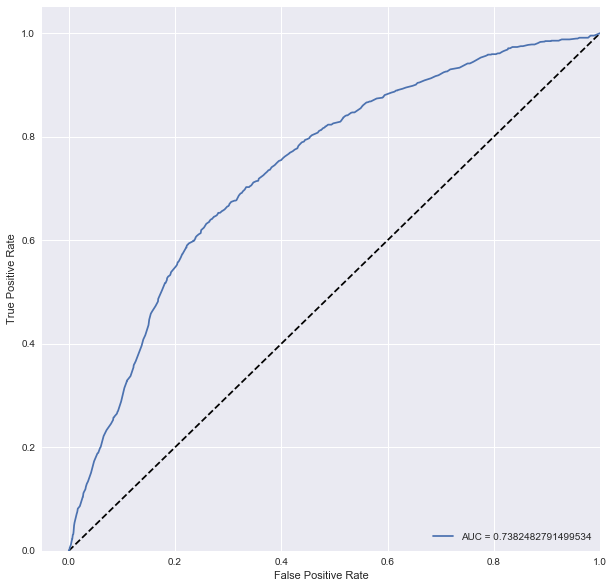

In [129]:
# making the AUC plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

The AUC thus obtained can be classified as 'fair'. The feature importance for random forest yeilds the following features with the highest importance:<br>
a. The vehicle addition predictive factor<br>
b. The background check predictive factor<br>
c. The channel category 'Referral' (demonstrating network effects)

The caveat of this approach is that:
1. I am not utilizing all data points
2. This is attempting to model a possibly non-linear parametric relationship using logistic regression
3. In the case of the overall model, TPR is still quite low.

In our objective of identifying the most important features to predict if a driver would actually complete the first trip, we have performed a step-wise analysis to understand which factors contribute in making the driver proceed with the next step of onboarding. This is a bit distorted due to the anomalies present in the data but I chose to ignore them since their numbers were small. 

One of the first decisions I took was to change the target metric due to class imbalance. This is important because in such a scenario where the negatives outweigh the positves almost 9:1, the models would always tend to predict that every entry will be negative. I thereby established **True Positive Rate (TPR)** as the desired metric.

Also, after establishing the objective of the exercise, I understood that since we have to predict on the basis of sign-up stage, the following metrics are no longer useful:
1. vehicle_make
2. vehicle_model
3. vehicle_year

STEP 1: For predicting if the driver would reach background check stage:-
The following features proved the most important:
1. signup_os
2. signup_channel
3. city_name

STEP 2: For predicting if the driver would reach vehicle addition stage:-
The following features proved the most important:
1. signup_os
2. signup_channel
3. city_name
(It is quite possible that bgc_pred_fac was more important than cities but that weight wasn't assigned to it by logistic regression.)

STEP 3: For predicting if the driver would reach first trip completion stage:-
The following features proved the most important:
1. vehicle_added_fac_pred
2. bgc_fac_pred
3. signup_channel

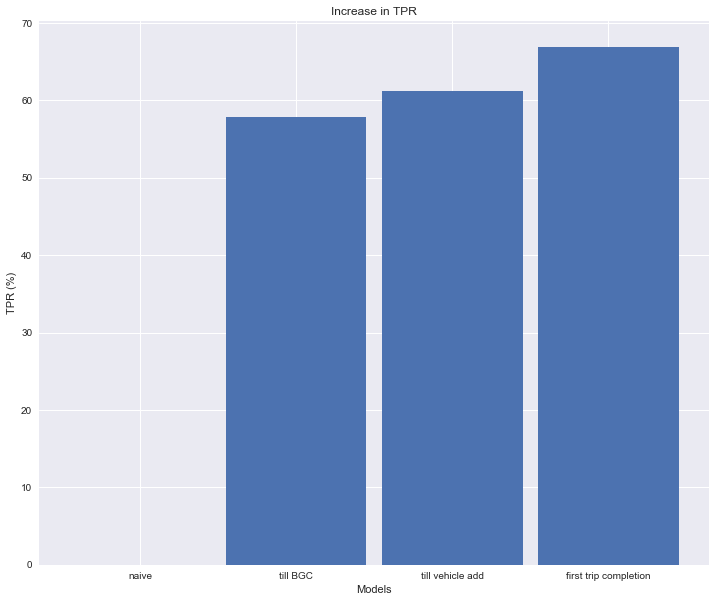

In [130]:
# plotting the increase in TPR
models = ['naive','till BGC','till vehicle add','first trip completion']
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(111)
ax.set_title('Increase in TPR')
ax.set_xlabel('Models')
ax.set_ylabel('TPR (%)')
y_pos = np.arange(4)
plt.bar(y_pos, tprval, width = 0.9, align = 'center', alpha = 1)
plt.xticks(y_pos, models)
plt.setp(ax1.get_xticklabels(), rotation = 30, horizontalalignment = 'center')
plt.show()

INSIGHTS:
1. Sign-ups have weekly trends
2. There is a constant stream of sign-ups via each of the channels - Organic, Referral and Paid
3. However, the conversion chances from the Referral channel are much higher
4. If the operating system is missing, there's an overwhelming chance that the driver will not complete the first trip. This maybe pure correlation and does not imply any causation.

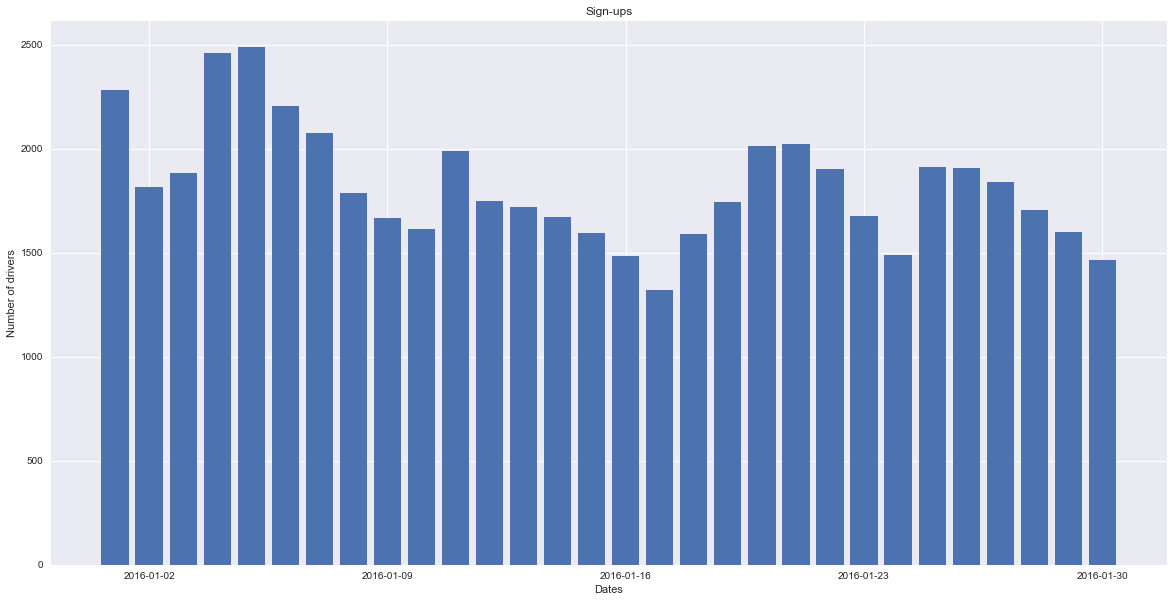

In [436]:
# revisiting the sign-ups in the month of January 2016
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
date = list(df.groupby('signup_date').groups.keys())
su = df.groupby(['signup_date'])['id'].count()
ax.bar(date, su)
ax.set_title('Sign-ups')
ax.set_xlabel('Dates')
ax.set_ylabel('Number of drivers')
plt.show()

As observed before, the sign-up data shows some weekly seasonality, with a slight dip on weekends. Let's get rid of this seasonality.

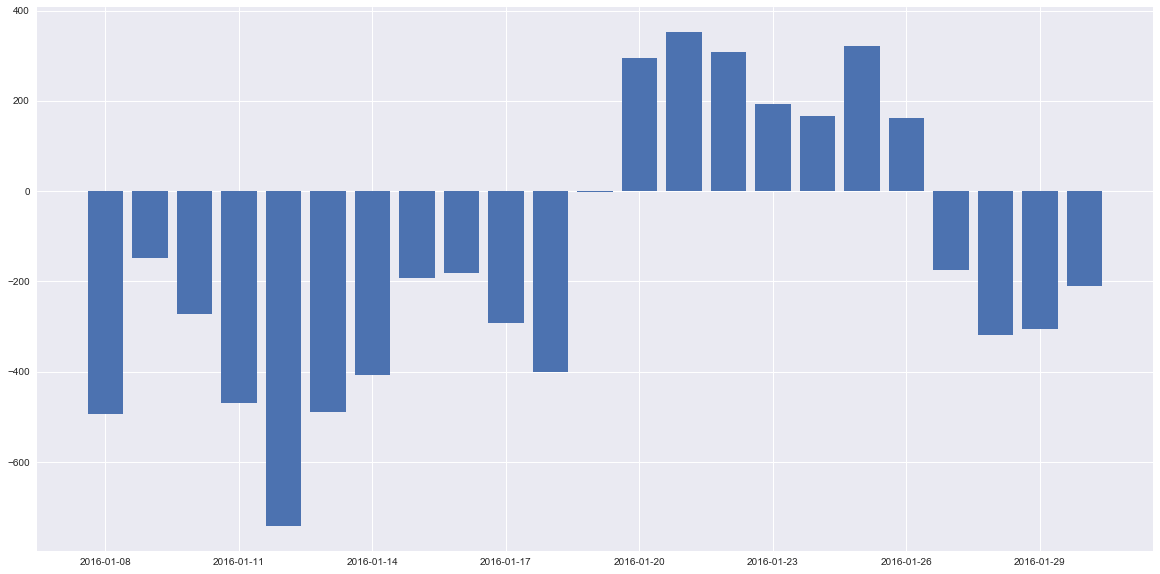

In [465]:
# removing weekly seasonality from the data
diff = []
for i in range(7, len(su_count)):
    value = su_count[i] - su_count[i - 7]
    diff.append(value)
temp = date.copy()
del temp[0:7]
f = plt.figure(figsize = (20,10))
plt.bar(temp, diff)
plt.show()

In [438]:
# checking the series for stationarity
result = sm.adfuller(diff)
result

(-0.95347514668055056,
 0.76985292593834698,
 7,
 15,
 {'1%': -3.9644434814814815,
  '10%': -2.6818144444444445,
  '5%': -3.0849081481481484},
 163.10359932786744)

Since the de-seasonalized time series is still non-stationary, I am taking the first-difference to stationarize it.

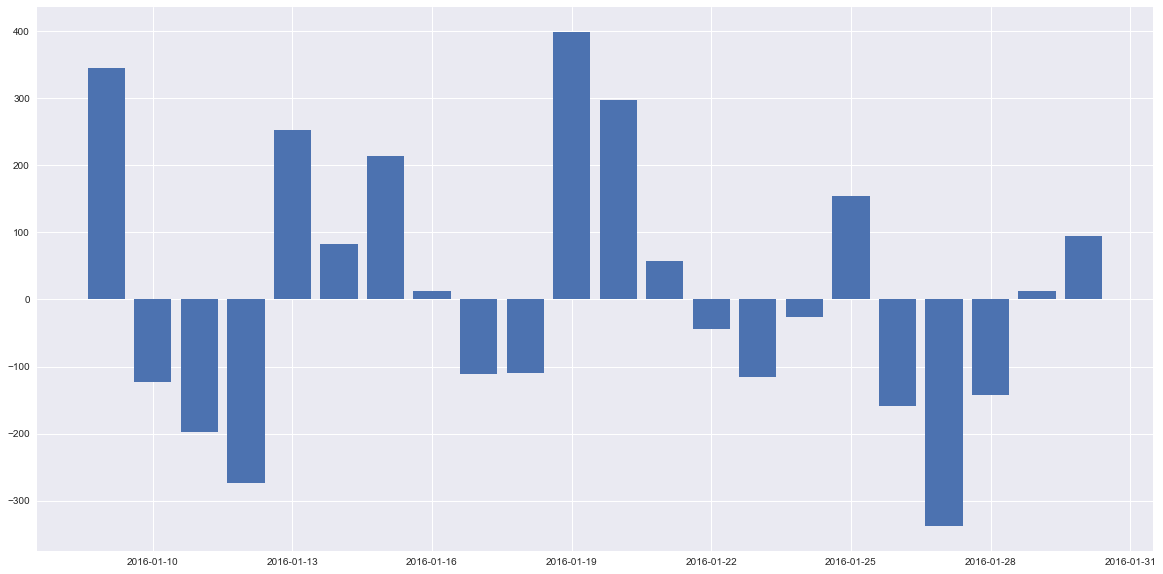

In [466]:
# taking first difference and plotting
n = len(diff)
diff2 = []
for i in range(1,n):
    diff2.append(diff[i] - diff[i-1])
temp2 = temp.copy()
del temp2[0]
f = plt.figure(figsize = (20,10))
plt.bar(temp2, diff2)
plt.show()

In [440]:
# checking the series for stationarity
result = sm.adfuller(diff2)
result

(-3.4226531844625776,
 0.010210444439325781,
 9,
 12,
 {'1%': -4.1378292824074077,
  '10%': -2.7144769444444443,
  '5%': -3.1549724074074077},
 131.64158650193968)

This time series is now stationary since the p-value of augumented Dickey-Fuller test < 0.05. We can now proceed with ARMA analysis.

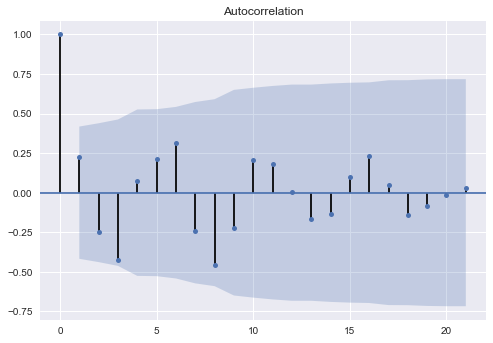

In [467]:
# plotting the ACF
plot_acf(diff2)

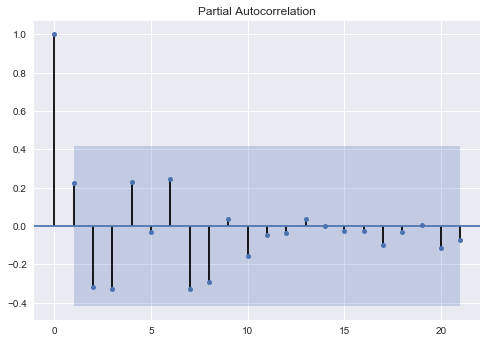

In [468]:
# plotting the PACF
plot_pacf(diff2)

As is visible above, the ACF and PACF are both inconclusive.  Since we do not have enough observations, hence we will not be able to exploit the apparent periodicity in the ACF plot too. Let's check if we can find the best fit values for p and q by minimizing AIC and BIC:

In [443]:
# obtaining p and q
res = sm.arma_order_select_ic(diff2, ic=['aic', 'bic'], trend='nc')
print('(p, q) for minimum AIC:,', res.aic_min_order)
print('(p, q) for minimum BIC:,', res.bic_min_order)

(p, q) for minimum AIC:, (2, 2)
(p, q) for minimum BIC:, (2, 2)


In [444]:
# modelling and forecasting using SARIMAX for subsequent week
numdays = 7
mod = smax.SARIMAX(diff2, trend='n', order=(2,0,2))
results = mod.fit()
print('Modelling completed.')
diff3 = []
diff3.append(results.forecast(numdays))
for i in range(numdays):
    diff.append(diff[-1] + diff3[0][i])
rev_su_count = su_count.copy()
for i in range(23,23 + numdays):
    rev_su_count.append(int(rev_su_count[i - numdays] + diff[i]))
print('Forecasting completed.')

Modelling completed.
Forecasting completed.


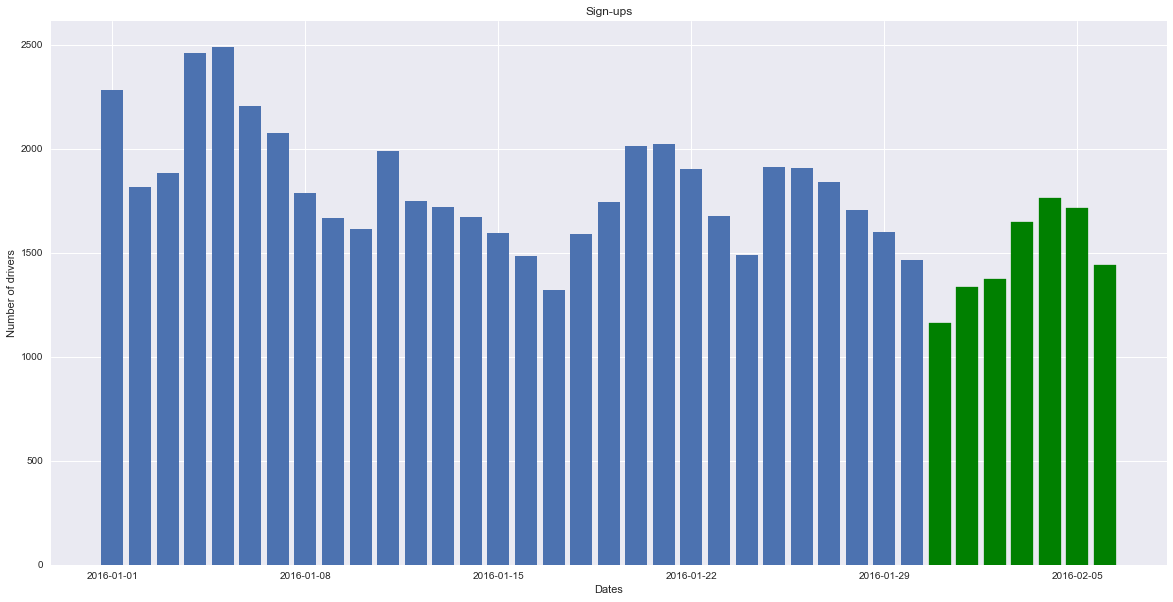

The number of sign-ups forecasted for next week: 10443


In [462]:
# plotting the forecasts for the subsequent week
rev_date = date.copy()
for i in range(numdays):
    rev_date.append(rev_date[-1] + pd.to_timedelta(1, unit='d'))
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
bars = ax.bar(rev_date, rev_su_count)
ax.set_title('Sign-ups')
ax.set_xlabel('Dates')
ax.set_ylabel('Number of drivers')
for i in range(30, 30 + numdays):
    bars[i].set_color('g')
plt.show()
print('The number of sign-ups forecasted for next week:', np.sum(rev_su_count[30:30 + numdays]))

The green bars denote the forecasted values of sign-ups for the next week. This can be extended to every week provided there is enough data to fit.

For validation of this model, I would look at more sign-up data from previous months and years and verify the predictions. I would also look at more data points such as the following:
1. The marketing spend and its relationship to the number of sign-ups
2. The trend of increase in drivers
3. The demographics of drivers signing-up